# Exploratory Data Analysis
This notebook is for exploratory data analysis, focused on the user-interface.

# Setup

## Settings

In [1]:
data_dir = '../../data/raw_data/zenodo.4008297/'

In [2]:
seed = 15324

## Imports

In [3]:
import os
import sys

In [4]:
import numpy as np
import pandas as pd
import pydub
from sklearn.pipeline import Pipeline
from sklearn.utils import check_random_state
from torch import Tensor
import torchaudio

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [6]:
# Local files
sys.path.append('../../meowlib/')
import utils, data_handling

## Parse Settings

In [7]:
rng = check_random_state(seed)

# Exploratory Analysis
Here are examples of pre-processing made easy.

## Load Data

### Training Data

In [8]:
# Load the data. The "extension" argument is optional.
data_fps = utils.discover_data(data_dir, extension='wav')

In [9]:
# All files
audio_segments = []
for data_fp in data_fps:
    audio = pydub.AudioSegment.from_file(data_fp)
    audio_segments.append(audio)

In [10]:
# Random single file
i_example = rng.randint(len(audio_segments))
audio_example = audio_segments[i_example]

In [11]:
# Formatted as an array
samples_list = data_handling.WavLoader().fit_transform(data_fps)
width = np.max([sample[0].size for sample in samples_list])
samples = np.zeros((len(samples_list), width))
for i, sample in enumerate(samples_list):
    samples[i, :sample[0].size] = sample[0]

  0%|                                                                                                                                                                                                                        | 0/440 [00:00<?, ?it/s]/Users/zhafensaavedra/repos/meow-by-meow/src/data_handling/../../meowlib/data_handling.py:48: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wavfile.read(data_fp)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 21960.49it/s]


### User Sample

In [12]:
user_data_fp = '../../data/raw_data/zachs_cats/pip_and_chell_wet_food.m4a'
user_audio = pydub.AudioSegment.from_file(user_data_fp)

In [13]:
# User signal
user_arr = np.array(user_audio.get_array_of_samples())
user_arr = user_arr / np.iinfo(user_arr.dtype).max
user_sig = Tensor(user_arr)

## Consistency Between Formats

In [14]:
wavs = data_handling.WavLoader().fit_transform(data_fps)

  0%|                                                                                                                                                                                                                        | 0/440 [00:00<?, ?it/s]/Users/zhafensaavedra/repos/meow-by-meow/src/data_handling/../../meowlib/data_handling.py:48: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wavfile.read(data_fp)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 24080.66it/s]


In [15]:
raw_audio_example = np.array(audio_example.get_array_of_samples())

In [16]:
torch_audio, torch_sample_rate = torchaudio.load(data_fps[i_example])
torch_audio = np.array(torch_audio[0])

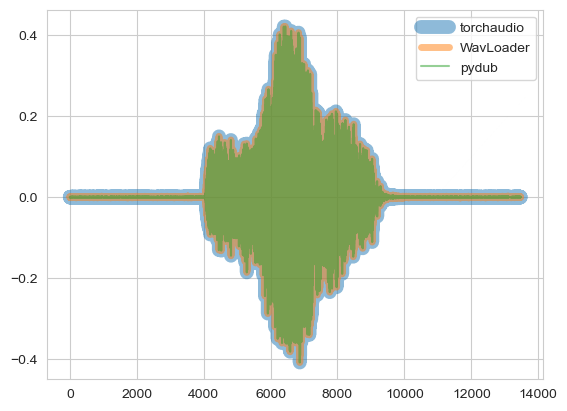

In [17]:
fig = plt.figure()
ax = plt.gca()

ax.plot(
    np.arange(torch_audio.size),
    torch_audio,
    alpha = 0.5,
    linewidth=10,
    label='torchaudio',
)

ax.plot(
    np.arange(wavs[i_example][0].size),
    wavs[i_example][0],
    alpha = 0.5,
    linewidth=5,
    label='WavLoader',
)

ax.plot(
    np.arange(raw_audio_example.size),
    raw_audio_example / np.iinfo(raw_audio_example.dtype).max,
    alpha = 0.5,
    label='pydub',
)

ax.legend()

## Extract One-Value-Per-File Entries

In [18]:
attrs = [
    'duration_seconds',
    'max_dBFS',
    'dBFS',
    'max_possible_amplitude',
    'max',
    'frame_rate', 
    'frame_width',
    'rms',
]

In [19]:
data = {}
for audio in audio_segments:
    
    # Easily-accessible values
    for attr in attrs:
        data.setdefault(attr, []).append(getattr(audio, attr))
df = pd.DataFrame(data)

/Users/Shared/miniconda3/envs/meow/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/meow/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/meow/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/meow/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

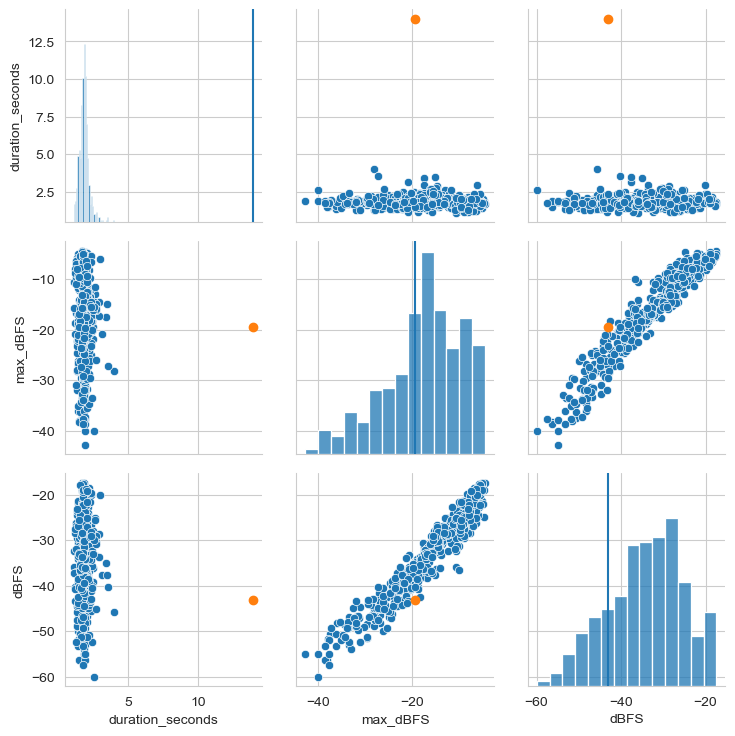

In [20]:
# Overall stats
g = sns.PairGrid(
    df,
    vars=['duration_seconds', 'max_dBFS', 'dBFS', ],
)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

fig = plt.gcf()
ax = plt.gca()

# Show user audio
for ax in fig.axes:
    xlabel = ax.get_xlabel()
    ylabel = ax.get_ylabel()
    
    if ylabel == 'Count':
        ax.axvline(
            getattr(user_audio, xlabel),
        )
    elif xlabel=='' or ylabel=='':
        continue
    else:
        ax.scatter(
            getattr(user_audio, xlabel),
            getattr(user_audio, ylabel),
        )

## Get Rolling Sample from User Sample
Pure audio, just to show an example.

In [21]:
# First, let's resample to the right frequency
resampler = torchaudio.transforms.Resample(user_audio.frame_rate, audio_example.frame_rate)
user_sig = resampler(user_sig)

In [22]:
# Get the window size
window_size_seconds = 4.
window_size = int(window_size_seconds * audio_example.frame_rate)

In [23]:
window_spacing_seconds = 1.
window_spacing = int(window_spacing_seconds * audio_example.frame_rate)

In [24]:
sig_size = user_sig.size()[0]
window_centers = np.arange(window_size//2, sig_size - window_size//2, window_spacing)

In [25]:
# Get the windows
user_arr_resampled = np.array(user_sig)
X = np.array([user_arr_resampled[j-window_size//2:j+window_size//2] for j in window_centers])

Text(0.5, 0, 'log10(max)')

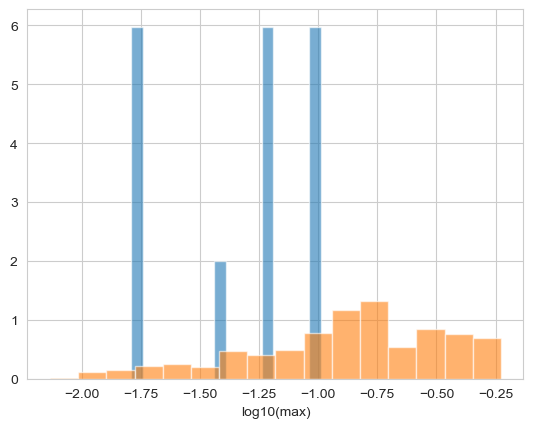

In [26]:
# Compare to raw training sample
fig = plt.figure()
ax = plt.gca()

ax.hist(
    np.log10(np.abs(X).max(axis=1)),
    bins=16,
    density=True,
    alpha=0.6,
)

ax.hist(
    np.log10(np.abs(samples).max(axis=1)),
    bins=16,
    density=True,
    alpha=0.6,
)

ax.set_xlabel('log10(max)')

Text(0.5, 0, 'log10(std)')

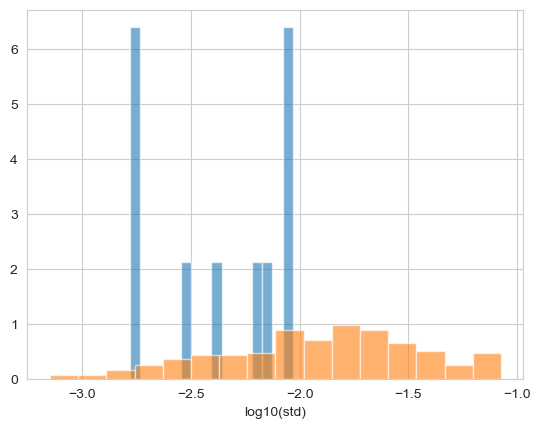

In [27]:
# Compare to raw training sample
fig = plt.figure()
ax = plt.gca()

ax.hist(
    np.log10(np.abs(X).std(axis=1)),
    bins=16,
    density=True,
    alpha=0.6,
)

ax.hist(
    np.log10(np.abs(samples).std(axis=1)),
    bins=16,
    density=True,
    alpha=0.6,
)

ax.set_xlabel('log10(std)')

## Preprocessing Consistency

In [28]:
loader = data_handling.FFMPEGLoader()
specgram_transformer = data_handling.SpecgramTransformer()

In [29]:
data_and_rates = loader.fit_transform(data_fps)
specgrams = specgram_transformer.fit_transform(data_and_rates)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 440/440 [00:01<00:00, 262.59it/s]


In [30]:
user_data_and_rates = loader.fit_transform([user_data_fp,])
user_specgrams = specgram_transformer.fit_transform(user_data_and_rates)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.26it/s]


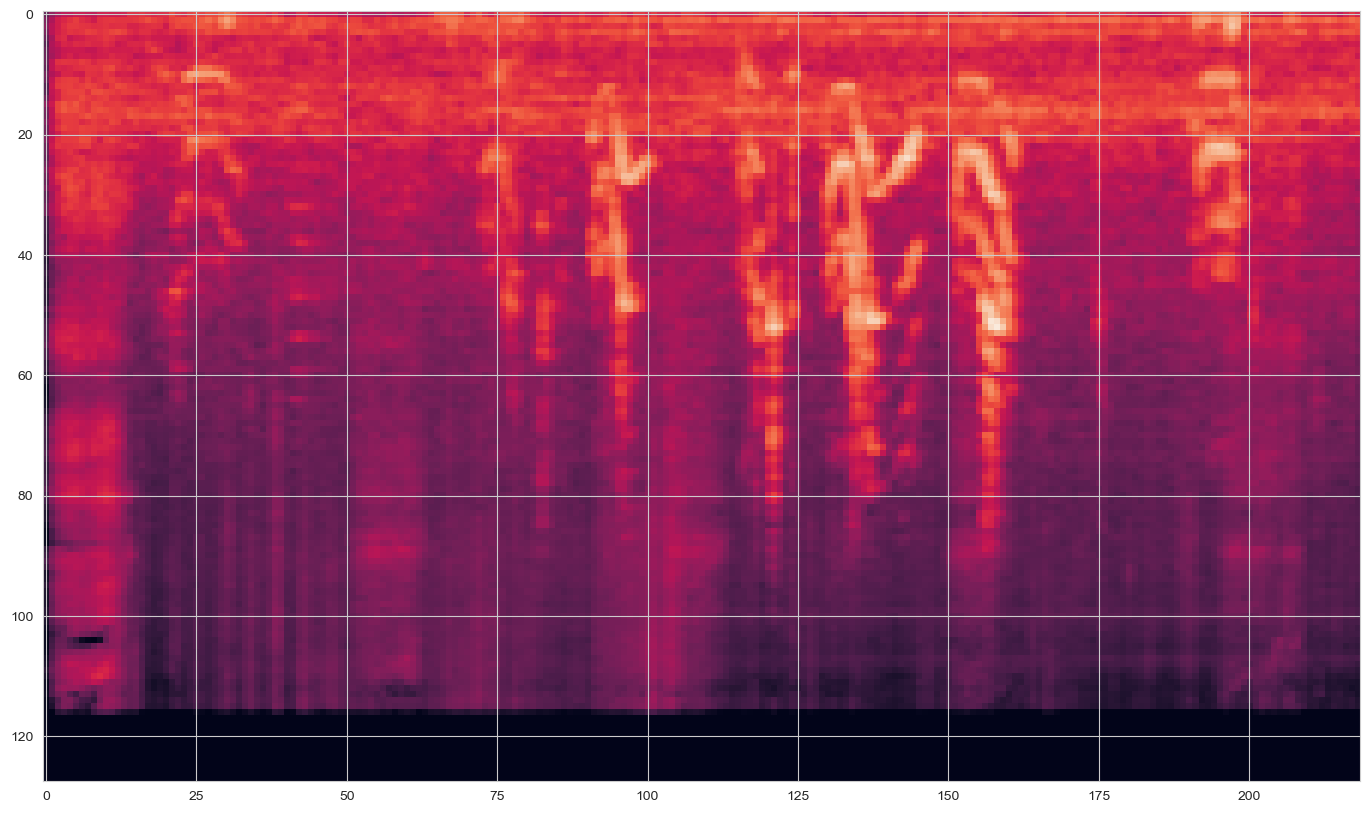

In [31]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca()

ax.imshow(user_specgrams[0])

In [32]:
# Check the sample rate of the specgrams
spec_rate = np.array([specgrams[i].shape[1] / audio_segments[i].duration_seconds for i in range(len(audio_segments))])

In [33]:
assert np.std(spec_rate) < 0.2, 'Variation in the sample rate is high.'

In [34]:
assert np.isclose(user_specgrams[0].shape[1] / user_audio.duration_seconds, np.mean(spec_rate), atol=0.5), \
    'Difference between user and training is high'

## Full Data Preprocessing Pipeline

In [35]:
preprocessing_pipeline = Pipeline([
    ('load', data_handling.FFMPEGLoader()),
    ('specgram', data_handling.SpecgramTransformer()),
    ('pad', data_handling.PadTransformer()),
])
preprocessing_pipeline

Pipeline(steps=[('load', FFMPEGLoader()), ('specgram', SpecgramTransformer()),
                ('pad', PadTransformer())])

In [36]:
X = preprocessing_pipeline.fit_transform(data_fps)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 440/440 [00:01<00:00, 336.47it/s]


In [37]:
X.shape

(440, 128, 64)

## Full User Data Preprocessing Pipeline

In [38]:
user_preprocessing_pipeline = Pipeline([
    ('load', data_handling.FFMPEGLoader()),
    ('specgram', data_handling.SpecgramTransformer()),
    ('split', data_handling.RollingWindowSplitter()),
    ('pad', data_handling.PadTransformer()),
])
user_preprocessing_pipeline

Pipeline(steps=[('load', FFMPEGLoader()), ('specgram', SpecgramTransformer()),
                ('split', RollingWindowSplitter()), ('pad', PadTransformer())])

In [39]:
user_X = user_preprocessing_pipeline.fit_transform([user_data_fp, ])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.10it/s]


In [40]:
user_X.shape

(12, 128, 64)

In [41]:
assert X.shape[1:] == user_X.shape[1:], 'Inconsistent shapes between user and training data.'

## Output Trimmed Sample
For building test cases.

In [46]:
cut_seconds = 5.
cut = int(user_audio.frame_rate * cut_seconds)

In [49]:
trimmed_user_audio = user_audio.get_sample_slice(cut)

In [60]:
export_fp = '../../data/raw_data/zachs_cats/pip_and_chell_wet_food.wav'

In [61]:
trimmed_user_audio.export(export_fp, format='wav')

<_io.BufferedRandom name='../../data/raw_data/zachs_cats/pip_and_chell_wet_food.wav'>